# 2.3 Kombiniertes Modell zur Ex Ante Prognose

### Pakete einladen

In [ ]:
#%% Pakete laden
# interaktive Ploterstellung
#%matplotlib ipympl
import ipympl
# Grundpakete /Einspellungen
import os
import copy
import sys
from math import ceil
# Datenorganisation
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.precision',2)
np.set_printoptions(precision=3)

# statsmodells für Benchmark
from statsmodels import api as sm
import statsmodels.formula.api as smf

# Datenvorbereitung
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import cluster
import statsmodels.api as sm

# Keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
# Laden der Model-API
from keras.models import Model, Sequential
from keras.models import load_model
# Laden des Moduls Dense (zur Erstellung vollvermaschte Layer)
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Conv1D,Conv2D,Concatenate,Flatten,MaxPooling1D,MaxPooling2D,GlobalMaxPooling1D, SeparableConv1D,TimeDistributed,Activation,BatchNormalization
from keras import layers,optimizers
# Callbacks zum Aufrufen während des Trainings
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Ausgabe der Modelarchitektur
from keras.utils import plot_model
import keras_tuner as kt

# Tensorflow
import tensorflow as tf
import tensorboard
from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Löschen alter Metadaten und damit Freigabe bislang belegter ports 
from tensorboard import manager
tensorboard_dir = manager._get_info_dir()
for instance in os.listdir(tensorboard_dir):
    os.remove(os.path.join(tensorboard_dir,instance))

import sys
sys.path.append(r'../src')
import Datenvorbereitung as dv
from Datenvorbereitung import Sample_Split_Scaler, sample_generator_lags

#Feiertage
import holidays

class summary():
    pass

In [ ]:
#Daten einladen
data_Preise = pd.read_excel(r"../data/Daten_Preise.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)

data_Preise = data_Preise.resample('h').ffill()
data_Preise.index = pd.to_datetime(data_Preise.index, format= "%Y-%m-%d %H:%M:%S")

data_Sonstige = pd.read_excel(r"../data/Daten_sonstige_h.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)
data_Sonstige.index = pd.to_datetime(data_Sonstige.index, format= "%d.%m.%Y %H:%M")

# Index in ein einheitliches Format übertragen
data_Preise.index = data_Preise.index.strftime("%Y-%m-%d %H:%M:%S")
index1 = data_Preise.index
data_Sonstige.index = data_Sonstige.index.strftime("%Y-%m-%d %H:%M:%S")
index2 = data_Sonstige.index

#Daten in einem DataFrame zusammenfügen
data_roh = pd.merge(data_Sonstige, data_Preise, left_index=True, right_index=True, how='inner')
data_roh.index = pd.to_datetime(data_roh.index)
data_roh["Day-of-year"] = np.sin(2*np.pi*data_roh.index.dayofyear/365)
data_roh

,Wochentag,Prognose Wind Offshore [MWh],Prognose Wind Onshore [MWh],Prognose Photovoltaik [MWh],Prognose Sonstige [MWh],Prognose Gesamt (Netzlast) [MWh],Prognose Residuallast [MWh],Biomasse [MWh],Wasserkraft [MWh],Wind Offshore [MWh],...,Volumen (+) [MWh],Volumen (-) [MWh],Preis [€/MWh],Temperatur,Kohle [€/t],Gas [€/MWh],CO2 [€/t],BIP,Verbraucherpreisindex,Day-of-year
ContractBegin,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00,2,551.75,10009.75,0.0,47097.50,43176.00,32614.50,4064.00,1680.25,473.75,...,0,-844,-37.56,3.40,64.7,7.24,20.35,100.0,100.0,0.09
2015-01-05 01:00:00,2,547.75,10287.75,0.0,44789.50,41597.75,30762.25,4069.25,1676.50,464.75,...,0,-589,-15.97,3.15,64.7,7.24,20.35,100.0,100.0,0.09
2015-01-05 02:00:00,2,542.50,10418.50,0.0,43457.00,40421.75,29460.75,4068.50,1661.50,461.50,...,0,-625,-15.35,2.83,64.7,7.24,20.35,100.0,100.0,0.09
2015-01-05 03:00:00,2,533.75,10601.75,0.0,43335.50,40404.25,29268.75,4067.00,1644.00,450.25,...,0,-494,-14.54,2.58,64.7,7.24,20.35,100.0,100.0,0.09
2015-01-05 04:00:00,2,521.75,10809.75,0.0,44479.50,41348.25,30016.75,4052.00,1632.00,453.50,...,0,-1294,-61.14,2.38,64.7,7.24,20.35,100.0,100.0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 20:00:00,5,1230.00,5514.75,252.0,45566.25,58524.25,51527.50,4814.00,1441.25,1352.00,...,414,0,412.93,11.32,286.5,85.04,85.04,108.2,116.6,0.90
2022-04-28 21:00:00,5,1133.75,6178.00,0.0,43957.25,56366.25,49054.50,4778.75,1412.75,1362.50,...,136,-19,314.46,9.72,286.5,85.04,85.04,108.2,116.6,0.90
2022-04-28 22:00:00,5,1017.25,6537.00,0.0,42921.75,53424.75,45870.50,4665.75,1409.00,1200.00,...,555,0,304.52,8.68,286.5,85.04,85.04,108.2,116.6,0.90


In [3]:
#Übertragen der Daten in einen anderen Dataframe als Backup
data_roh
df_cleaned = data_roh

## Feature Engineering

In [4]:
#Ideen für Feature Engineering

# Stunde des Tages
df_cleaned["Stunde"] = np.sin(2*np.pi*df_cleaned.index.hour/24)
#Monat
df_cleaned['Monat'] = np.sin(2*np.pi*df_cleaned.index.month/12)
#Wochentag
df_cleaned['Wochentag']=np.sin(2*np.pi*df_cleaned['Wochentag']/7)
#Feiertage
de_holidays = holidays.Germany(years=range(2015,2022))
df_cleaned['Feiertag'] = df_cleaned.index.isin(de_holidays).astype(int)

#Berücksichtigung Ausgleichsenergie spez. Kosten 
df_cleaned["Ausgleichsenergie [€]"] = (df_cleaned["Volumen (+) [MWh]"]+df_cleaned["Volumen (-) [MWh]"])*df_cleaned["Preis [€/MWh]"]

#Kraftwerke mit Preisen
df_cleaned['Summe_CO2'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4
df_cleaned['Summe_Kohle'] = df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228
df_cleaned['Kraftwerke_CO2'] = (df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4)*df_cleaned['CO2 [€/t]']
df_cleaned['Kraftwerke_Kohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228 )*df_cleaned['Kohle [€/t]']
df_cleaned['Kraftwerke_Gas'] = df_cleaned['Erdgas [MWh]']*df_cleaned['Gas [€/MWh]']
df_cleaned['Kosten_Erdgas'] = (df_cleaned['Erdgas [MWh]']* df_cleaned['Gas [€/MWh]'])+ (df_cleaned['Erdgas [MWh]']*0.4*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Braunkohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Braunkohle [MWh]']*1.188*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Steinkohle'] = (df_cleaned['Steinkohle [MWh]']*0.1228*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Steinkohle [MWh]']*0.95*df_cleaned['CO2 [€/t]'])
df_cleaned['Kraftwerke_Fossil'] = df_cleaned['Kraftwerke_Gas']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_CO2']

#Quellen-CO2: 
#Braunkohle: hhttps://www.bund-nrw.de/braunkohle/hintergruende-und-publikationen/braunkohlenkraftwerke-contra-klimaschutz/
#Steinkohle: https://www.brisant.de/braunkohle-umwelt-100.html
#Erdgas: https://www.ise.fraunhofer.de/de/presse-und-medien/news/2019/33-prozent-weniger-co2-emissionen-durch-brennstoffwechsel-von-kohle-auf-gas.html

#Quellen-Kohle:
#Braunkohle: https://agrarplus.at/heizwerte-aequivalente.html
#Steinkohle: https://www.unitjuggler.com/energy-umwandeln-von-MWh-nach-tSKE.html

# Anteil Erneuerbarer
df_cleaned['Summe_Ern']= df_cleaned[['Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]', 'Sonstige Erneuerbare [MWh]','Biomasse [MWh]', 'Wasserkraft [MWh]']].sum(axis=1)
proz_ern = df_cleaned['Summe_Ern'] / (df_cleaned['Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Anteil Erneuerbarer'] = proz_ern
df_cleaned['Anteil_PV'] = df_cleaned['Photovoltaik [MWh]']/df_cleaned['Summe_Ern']

df_cleaned['Prognose_Summe_Ern']= df_cleaned[['Prognose Wind Offshore [MWh] ', 'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]']].sum(axis=1)
prog_proz_ern = df_cleaned['Prognose_Summe_Ern'] / (df_cleaned[' Prognose Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Prognose Anteil Erneuerbarer'] = prog_proz_ern

# Überschuss Erzeugung
summe_erzeugung = df_cleaned[['Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]']].sum(axis=1)
df_cleaned['Überschuss'] = summe_erzeugung - df_cleaned['Gesamt (Netzlast) [MWh]']

# Abweichung Prognose Residuallast
df_cleaned['Abweichung_Prognose_Residuallast'] = (df_cleaned['Residuallast [MWh]'] - df_cleaned['Prognose Residuallast [MWh]'])/df_cleaned['Prognose Residuallast [MWh]']


#mögliche Interaktionen zwischen Features
df_cleaned['Int_Gas'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Gesamt (Netzlast) [MWh]']
df_cleaned['Int_Gas_Resi'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Residuallast [MWh]']
df_cleaned['Int_CO2_Erz'] = summe_erzeugung*df_cleaned['CO2 [€/t]']
df_cleaned['Int_CO2_Kohle'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95*df_cleaned['CO2 [€/t]']
df_cleaned['Int_Ern_Foss'] = df_cleaned['Anteil Erneuerbarer'] * df_cleaned['Erdgas [MWh]']*df_cleaned['Steinkohle [MWh]']*df_cleaned['Braunkohle [MWh]']
df_cleaned['Int_Preise'] = df_cleaned['Kraftwerke_CO2']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_Gas']
df_cleaned['Int_Pumpspeicher'] = df_cleaned['Pumpspeicher [MWh]']/df_cleaned['Kraftwerke_Fossil']

#df_cleaned['Std_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=24).std()
#df_cleaned['Std_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=24).std()
#df_cleaned['Std_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=24).std()
#df_cleaned['Std_Erneuerbare_Tag'] = df_cleaned['Summe_Ern'].rolling(window=24).std()

df_cleaned = df_cleaned.dropna()
print(df_cleaned.columns)

df_cleaned = df_cleaned.loc[:'2021-05-01']

#Gleitender Durchschnitt Preise
#df_cleaned['Moving_Average_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=2500).mean()

Index(['Wochentag', 'Prognose Wind Offshore [MWh] ',
       'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]',
       'Prognose Sonstige [MWh]', ' Prognose Gesamt (Netzlast) [MWh]',
       'Prognose Residuallast [MWh]', 'Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]', 'Gesamt (Netzlast) [MWh]',
       'Residuallast [MWh]', 'Pumpspeicher [MWh]', 'Nettoexport [MWh]',
       'Day-ahead Auktion (volumengewichtet) [€/MWh]', 'Volumen (+) [MWh]',
       'Volumen (-) [MWh]', 'Preis [€/MWh]', 'Temperatur', 'Kohle [€/t]',
       'Gas [€/MWh]', 'CO2 [€/t]', 'BIP ', 'Verbraucherpreisindex',
       'Day-of-year', 'Stunde', 'Monat', 'Feiertag', 'Ausgleichsenergie [€]',
       'Summe_CO2', 'Summe_Kohle', 'Kraftwerke_CO2', 'Kraftwerke_Koh

C:\Users\janko\AppData\Local\Temp\ipykernel_14096\1483180695.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_cleaned['Feiertag'] = df_cleaned.index.isin(de_holidays).astype(int)


In [5]:
# Vorgaben zur Datentrennung
sections=(.6,.2,.2)
shuffle=False

features = df_cleaned[['Stunde', 'Wochentag', 'Day-of-year', 'Monat', 'Kraftwerke_Kohle', 'Kraftwerke_Gas', 'Kraftwerke_CO2',
                       'Ausgleichsenergie [€]', 'Anteil Erneuerbarer', 'Überschuss','Int_Pumpspeicher', 'Nettoexport [MWh]',
                       'Residuallast [MWh]', 'Abweichung_Prognose_Residuallast', 'Int_Gas_Resi', 'Temperatur',
                       'Kernenergie [MWh]','Erdgas [MWh]', 'Braunkohle [MWh]', 'Steinkohle [MWh]','Prognose Wind Offshore [MWh] ',
                       'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]',' Prognose Gesamt (Netzlast) [MWh]','Biomasse [MWh]', 
                       'Wasserkraft [MWh]','Sonstige Erneuerbare [MWh]', 'Erzeugung Pumpspeicher [MWh]', 'Feiertag','Prognose Residuallast [MWh]',
                      'Prognose Anteil Erneuerbarer','Prognose Sonstige [MWh]']]

In [6]:
# Vorbereitete Klasse
preprocessing = Sample_Split_Scaler()
# Unterteilung der Samples, Auswahl der Skalierungsmethode "MinMax" vs. "standard"
preprocessing.split_sample(features.loc[:],df_cleaned.loc[:, 'Day-ahead Auktion (volumengewichtet) [€/MWh]'].values.reshape(-1,1),shuffle=False,sections =sections)
preprocessing.scaler('MinMax')

In [7]:
# Struktur zur Speicherung Parameter des Einzellaufs
so_par = summary()

In [8]:
# Auswahl der verwendeten Variablen
so_par.inputvars = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,24,25,27,28,29] 
so_par.futurex_var =[20,21,22,23,29,30,31] 
so_par.futurex_anz =7

In [9]:
# Festlegen der Lags
so_par.lags = [[0], [0], [0], [0],
               [0,1,2], [0,1,2], [0,1,2], [0,1,2], [0,1,2],
               [0,1,2], [0,1,2], [0,1,2], [0,1,2], [0,1,2],
               [0,1,2], [0,1,2], [0,1,2], [0,1,2], [0,1,2],
                 [0,1,2], [0,1,2],[0,1,2], [0,1,2],[0,1,2], [0]]

In [10]:
# Festlegung des maximal auftretenden Lags in der Liste

so_par.lag_max = max(map(max, so_par.lags))
lengths_list = list(map(len, so_par.lags))
so_par.anz_features_hist = sum(lengths_list)
# Beziehung wird als dictionary gespeichert
so_par.dict_input_lags = dict(zip(so_par.inputvars, so_par.lags))

#Ausgabe
print('maximales lag',so_par.lag_max)
print('Anzahl der features für das LSTM:',so_par.anz_features_hist)
print('feature:[lags]:',so_par.dict_input_lags)

maximales lag 2
Anzahl der features für das LSTM: 65
feature:[lags]: {0: [0], 1: [0], 2: [0], 3: [0], 4: [0, 1, 2], 5: [0, 1, 2], 6: [0, 1, 2], 7: [0, 1, 2], 8: [0, 1, 2], 9: [0, 1, 2], 10: [0, 1, 2], 11: [0, 1, 2], 12: [0, 1, 2], 13: [0, 1, 2], 14: [0, 1, 2], 15: [0, 1, 2], 16: [0, 1, 2], 17: [0, 1, 2], 18: [0, 1, 2], 19: [0, 1, 2], 24: [0, 1, 2], 25: [0, 1, 2], 27: [0, 1, 2], 28: [0, 1, 2], 29: [0]}


In [11]:
# betrachtete timesteps pro sample
so_par.timesteps = 72
# wieviele outputs sollen erzeugt werden (Prognosehorizont)
so_par.horizon   = 24 

### Modellstruktur

In [12]:
# Input der Daten von t-1
past_inputs = Input(shape=(so_par.timesteps, so_par.anz_features_hist))

# Erste LSTM-Schicht
encoder = LSTM(128, return_sequences=True, return_state=True) 
encoder_outputs, state_h, state_c = encoder(past_inputs)

# Zweite LSTM-Schicht
encoder2 = LSTM(128, return_sequences=False, return_state=True) 
encoder_outputs, state_h, state_c = encoder2(encoder_outputs)

encoder_outputs_repeat = layers.RepeatVector(so_par.horizon)(encoder_outputs)

#Input der Daten über t-1 hinaus (Prognosen)
future_inputs = Input(shape=(so_par.horizon, so_par.futurex_anz))

#Zusammenfassen der Inputs
future_inputs_all = Concatenate()([encoder_outputs_repeat, future_inputs])
decoder = LSTM(128, return_sequences=True)(future_inputs_all, initial_state=[encoder_outputs, state_c]) 

#abschließende Verarbeitung 
x =TimeDistributed(Dense(64, activation="elu"))(decoder) 
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)   
Out = Dense(1, activation="linear")(x)

model_solo = Model(inputs = [past_inputs, future_inputs], outputs = Out)
model_solo.summary()

del past_inputs, future_inputs, Out, x

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 65)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 72, 128), │     99,328 │ input_layer[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 128),     │    131,584 │ lstm[0][0]        │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 24, 128)   │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 135)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 128)   │    135,168 │ concatenate[0][0… │
│                     │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 24, 64)    │      8,256 │ lstm_2[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 64)    │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24, 1)     │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 378,561 (1.44 MB)

 Trainable params: 378,561 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

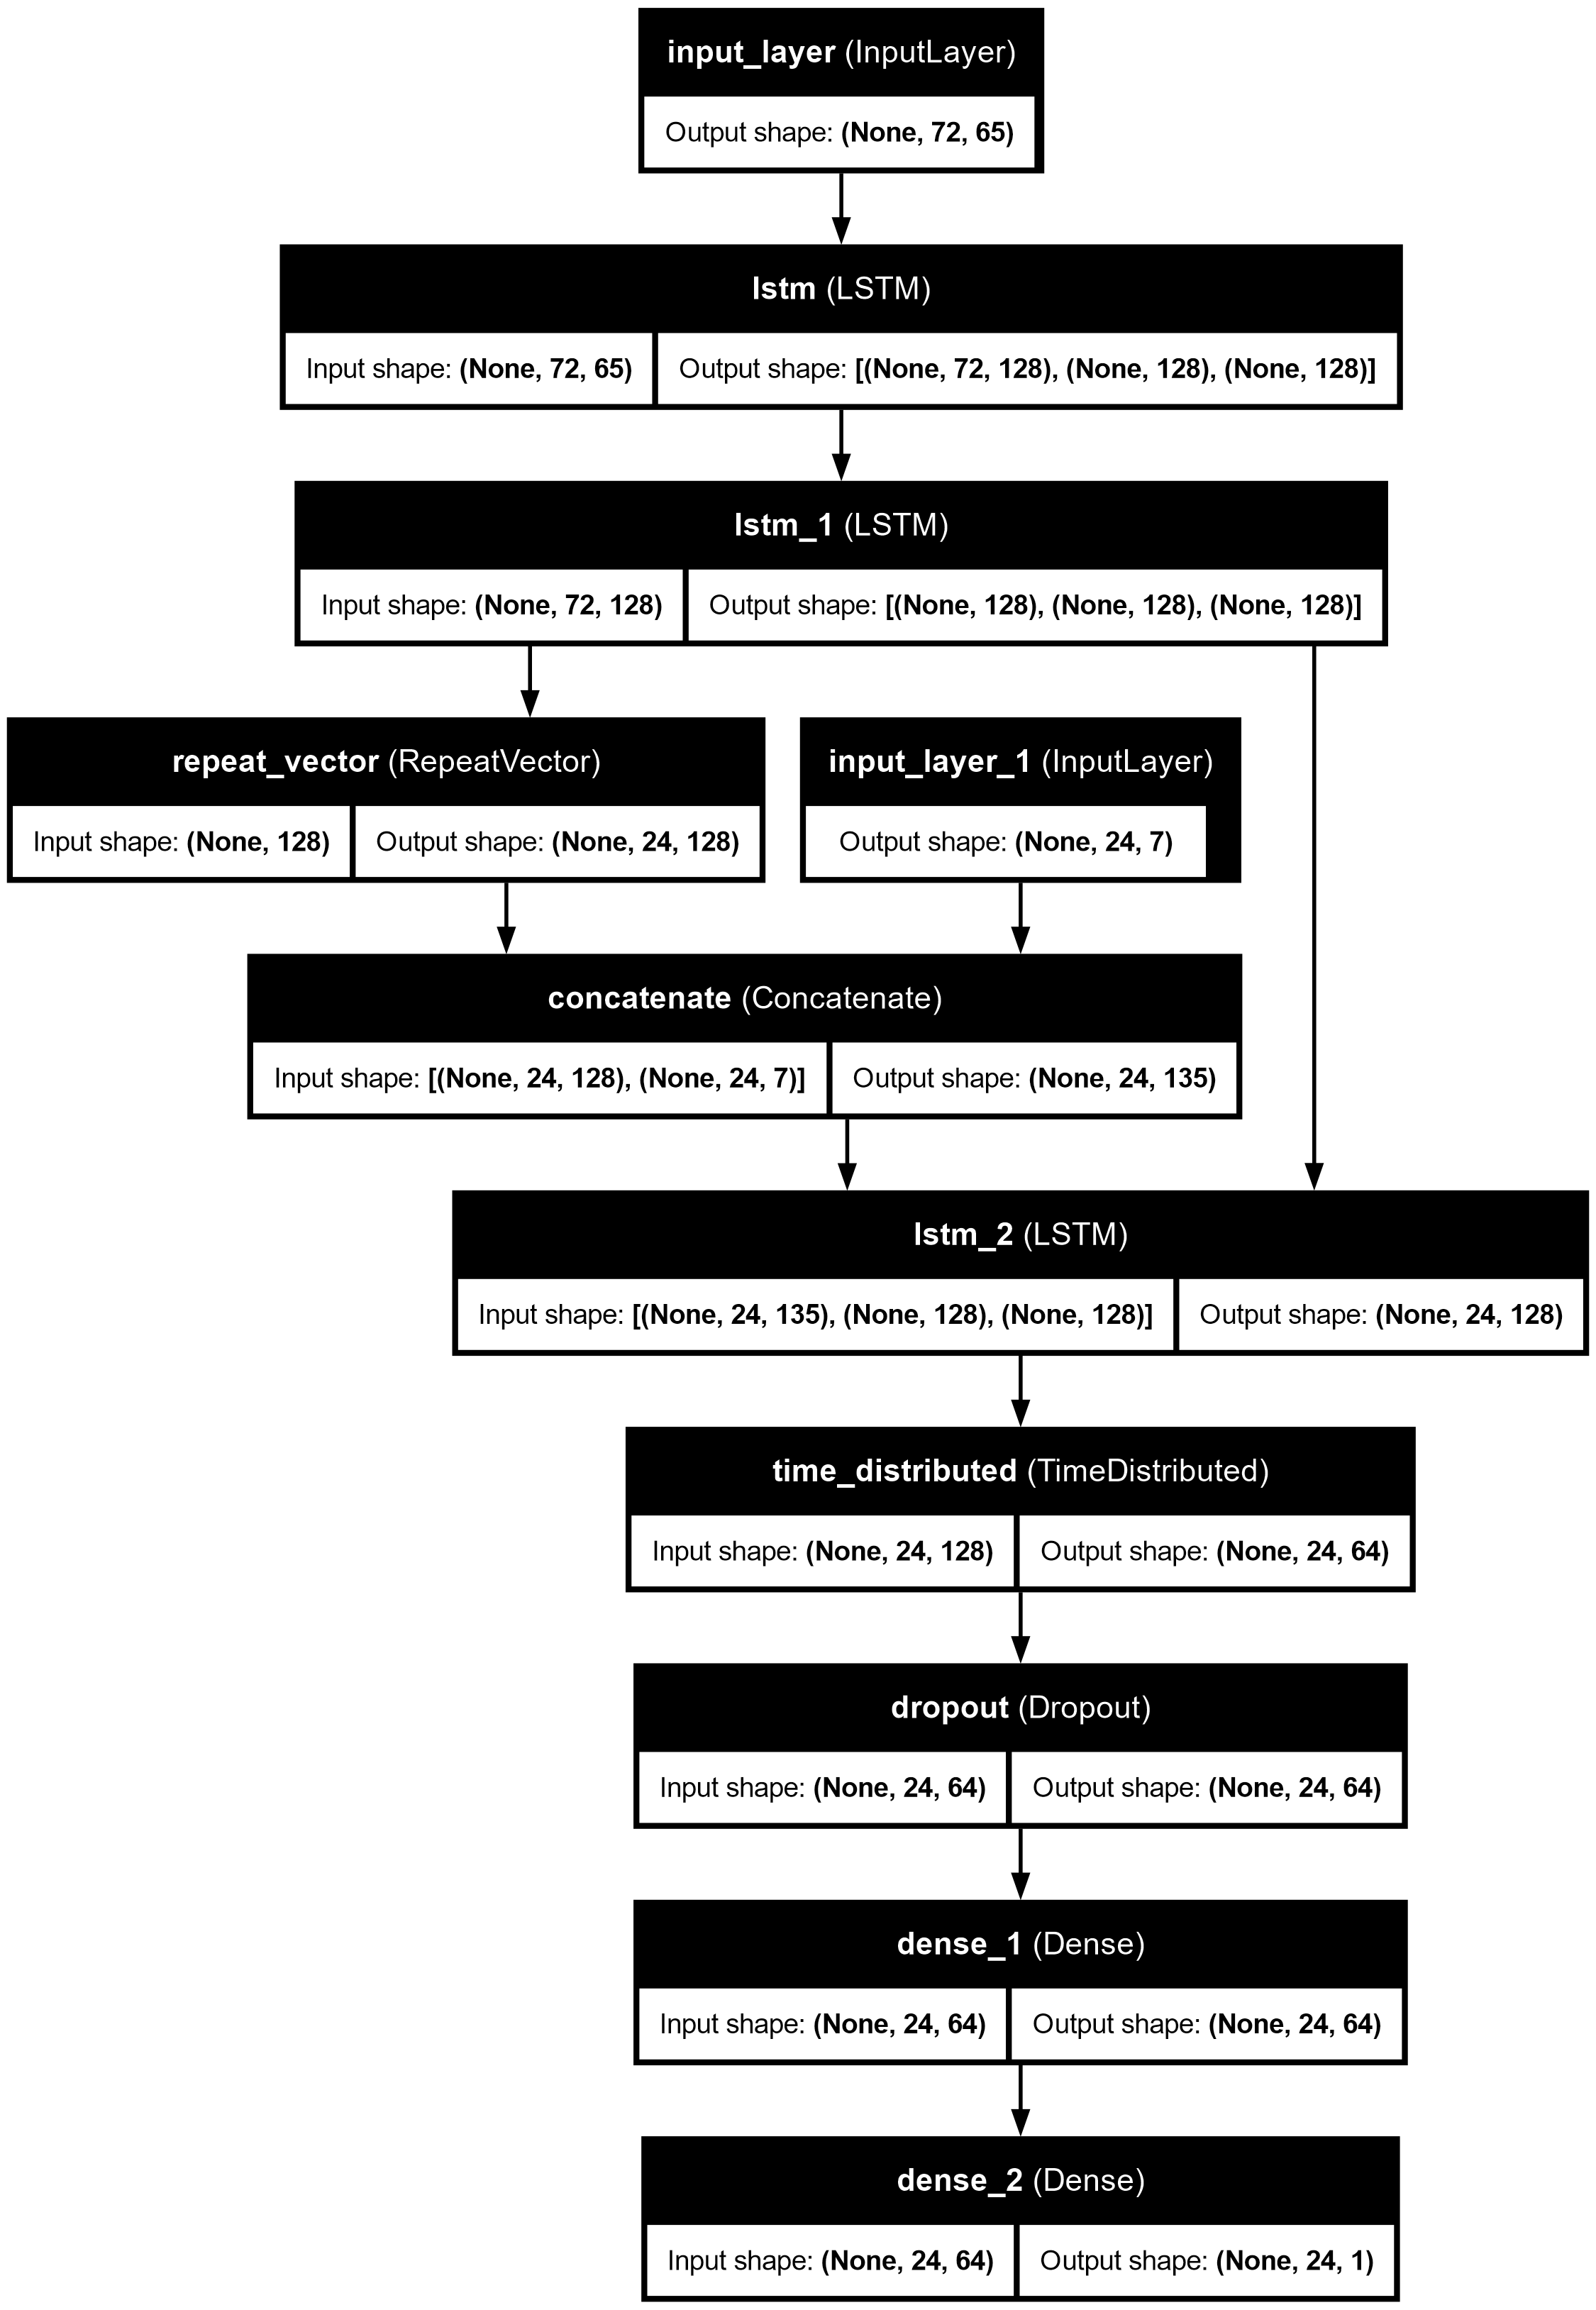

In [13]:
plot_model(model_solo, show_shapes=True, show_layer_names=True)

### Modell trainieren

In [15]:
# Eigenschaften des Optimierers
so_par.epochs=200
so_par.batch_size =1680
so_par.lr = 0.00005

# Generator initialisieren
so_obj = summary()
so_obj.gen_train = sample_generator_lags(preprocessing.x_norm[0],preprocessing.y_norm[0],so_par.timesteps,so_par.horizon,so_par.dict_input_lags,so_par.lag_max,so_par.futurex_var,so_par.batch_size,so_par.epochs)
so_obj.gen_val = sample_generator_lags(preprocessing.x_norm[1],preprocessing.y_norm[1],so_par.timesteps,so_par.horizon,
                                       so_par.dict_input_lags,so_par.lag_max,so_par.futurex_var,so_par.batch_size,so_par.epochs)

so_par.steps_train = ceil((len(preprocessing.x_norm[0]) - (so_par.timesteps + so_par.horizon+so_par.lag_max))/so_par.batch_size)
so_par.steps_val =   ceil((len(preprocessing.x_norm[1]) - (so_par.timesteps + so_par.horizon+so_par.lag_max))/so_par.batch_size)


model_solo.compile(loss='mse', optimizer=optimizers.Adam(learning_rate= so_par.lr), metrics=['mae'])

# Trainieren des Modells

so_obj.history = model_solo.fit(so_obj.gen_train, epochs=so_par.epochs, steps_per_epoch=so_par.steps_train, \
                              validation_data=so_obj.gen_val, validation_steps=so_par.steps_val, \
                              callbacks=[EarlyStopping(monitor='val_loss', patience=50), 
                                         ModelCheckpoint(
                                            filepath = 'so_par.keras',
                                            monitor="val_loss",
                                            verbose=1,
                                            save_best_only=True,
                                            mode="auto",
                                            save_freq="epoch",
                                        ),
                                         tf.keras.callbacks.TensorBoard(log_dir = "logs2/lstm_simple",histogram_freq=1)])

Epoch 1/200
 1/20 ━━━━━━━━━━━━━━━━━━━━ 9:15 29s/step - loss: 0.4585 - mae: 0.6714

KeyboardInterrupt: 

### Ergebnisse

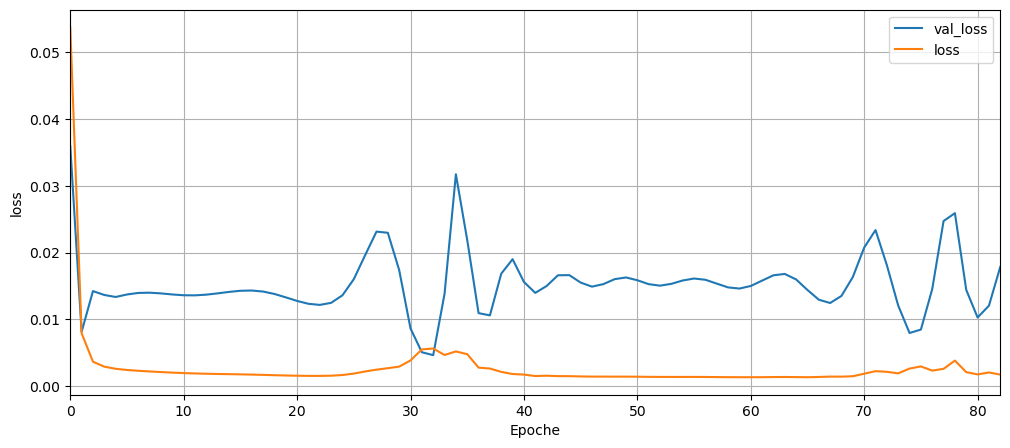

In [60]:
# ab der xten epoche
epoch_shown = 0
fig, ax =plt.subplots(nrows=1,ncols=1,**{'figsize': (12, 5)})
ax.plot(so_obj.history.history['val_loss'][epoch_shown:],label='val_loss')
ax.plot(so_obj.history.history['loss'][epoch_shown:],label= 'loss')
ax.set(xlabel='Epoche',ylabel='loss')
ax.legend();
ax.grid(visible=True)
del fig,ax,epoch_shown

In [61]:
### Bestes Modell laden
model_solo = keras.saving.load_model('so_par.keras')

In [62]:
#%% Anwendung auf die Testdaten: Berechnung Verlust (Loss and metric)

so_out=summary()
gen=[];so_out.x_in=[];so_out.y_in=[]
for i in range(3):
    gen.append(sample_generator_lags(preprocessing.x_norm[i],preprocessing.y_norm[i],
                                     so_par.timesteps,so_par.horizon,so_par.dict_input_lags,so_par.lag_max,so_par.futurex_var,so_par.batch_size,1))
    tmp=next(gen[i])
    so_out.x_in.append(tmp[0]);
    so_out.y_in.append(tmp[1]);
so_out.loss =np.zeros((3,2))    
for i in range (3):
    #print(so_out.x_in[i][0].shape, so_out.x_in[i][1].shape)
    so_out.loss[i,:]=model_solo.evaluate(so_out.x_in[i],so_out.y_in[i])

so_out.vergleich = pd.DataFrame(data = so_out.loss,index=["MAETrain","MAEVal","MAETest"],columns=["Loss","MAE"])

# Rücktransformierung des Fehlers
if preprocessing.scaler_method=='MinMax':
    so_out.vergleich.iloc[:,:] =np.round(preprocessing.scalerY.inverse_transform(so_out.vergleich)-preprocessing.scalerY.min_,0)
else:
    so_out.vergleich.iloc[:,:]  =np.round(preprocessing.scalerY.inverse_transform(so_out.vergleich)-preprocessing.scalerY.mean_,0)
so_out.vergleich
del tmp,gen

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0058 - mae: 0.0676
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0053 - mae: 0.0619
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0050 - mae: 0.0542


In [63]:
so_out.ypred_norm=[];[so_out.ypred_norm.append(model_solo.predict(so_out.x_in[i])) for i in range(3)]
#**Inverse Scalierung**
so_out.ypred=[];
[so_out.ypred.append(preprocessing.scalerY.inverse_transform(np.squeeze(so_out.ypred_norm[i], axis=-1))) for i in range(3)];

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


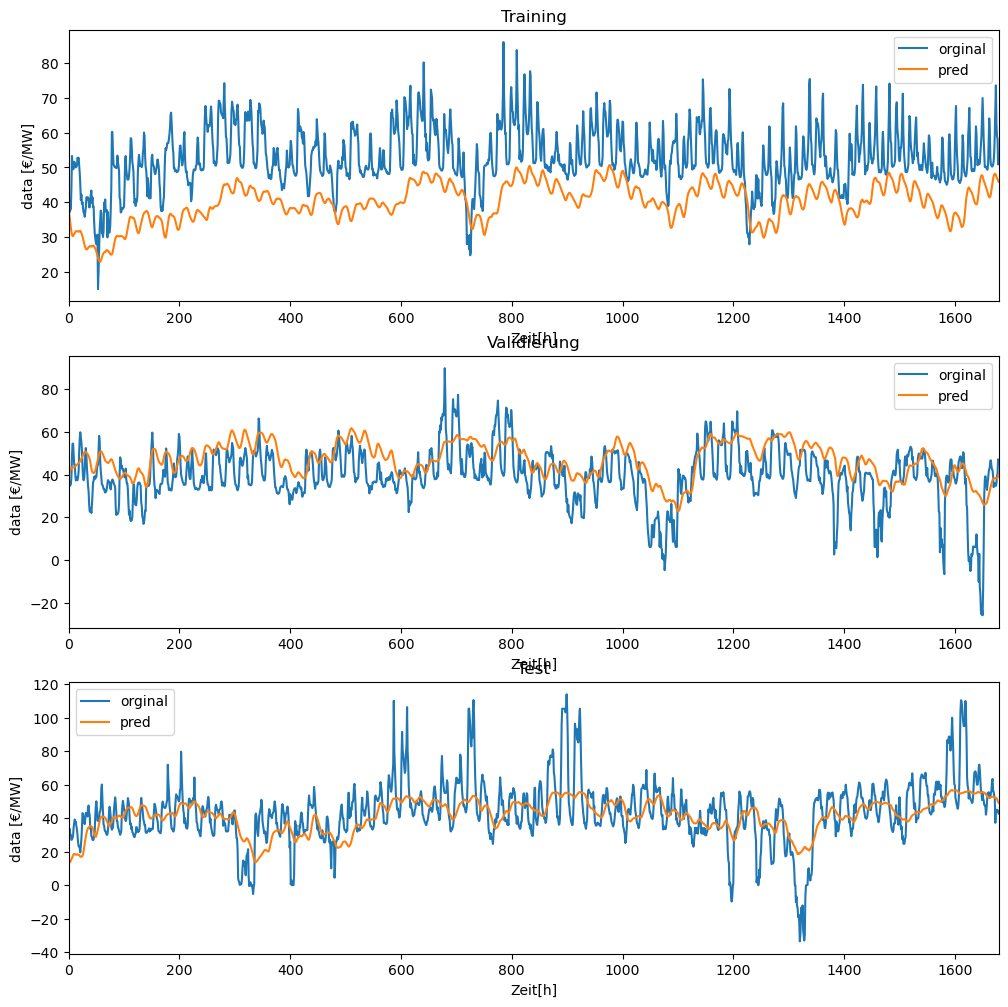

In [64]:
# gewählter Prognoseschritt
step = 24
if step > so_par.horizon:
    step = so_par.horizon

fig, ax =plt.subplots(nrows=3,ncols=1,**{'figsize': (12, 12)});lab=["Training","Validierung","Test"]
for i in range(3):
    if so_par.horizon >1:
        so_out.y_real = preprocessing.scalerY.inverse_transform(so_out.y_in[i][:,step-1].reshape(-1, 1))
    else:
        so_out.y_real = preprocessing.scalerY.inverse_transform(so_out.y_in[i].reshape(-1, 1))
        
    ax[i].plot(so_out.y_real,label='orginal',linestyle=None);
    ax[i].plot(so_out.ypred[i][:, step-1],label='pred',linestyle=None);
    ax[i].set(ylabel="data [€/MW]",xlabel="Zeit[h]",title=lab[i]);
    ax[i].legend()
    
del fig,ax,lab,step


### Hyperparameteroptimierung

In [12]:
# Festlegung der verschiedenen Hyperparameter
HP_units_dense = hp.HParam(name="units_dense",domain = hp.Discrete([64, 128]))     # Anzahl der Neuronen Dense-Layer
HP_units_LSTM = hp.HParam(name="units_LSTM",domain = hp.Discrete([32, 64, 128]))     # Anzahl der Neuronen LSTM-Layer
HP_lr = hp.HParam(name = "lr", domain= hp.Discrete([0.00005, 0.0001]))     # Lernrate
HP_timesteps = hp.HParam(name='timesteps', domain=hp.Discrete([72, 168]))

In [13]:
def single_run(hparams):

    # timesteps setzen
    so_par.timesteps = hparams[HP_timesteps] #72, 168

    # Modell aufbauen
    # Input der Daten von t-1
    past_inputs = Input(shape=(so_par.timesteps, so_par.anz_features_hist))

    # Erste LSTM-Schicht
    encoder = LSTM(hparams[HP_units_LSTM], return_sequences=True, return_state=True)  # 32,64 oder 128
    encoder_outputs, state_h, state_c = encoder(past_inputs)

    # Zweite LSTM-Schicht
    encoder2 = LSTM(hparams[HP_units_LSTM], return_sequences=False, return_state=True) # 32,64 oder 128
    encoder_outputs, state_h, state_c = encoder2(encoder_outputs)

    encoder_outputs_repeat = layers.RepeatVector(so_par.horizon)(encoder_outputs)

    #Input der Daten über t-1 hinaus (Prognosen)
    future_inputs = Input(shape=(so_par.horizon, so_par.futurex_anz))

    #Zusammenfassen der Inputs
    future_inputs_all = Concatenate()([encoder_outputs_repeat, future_inputs])
    decoder = LSTM(hparams[HP_units_LSTM], return_sequences=True)(future_inputs_all, initial_state=[encoder_outputs, state_c]) # 32,64 oder 128

    #abschließende Verarbeitung 
    x = TimeDistributed(Dense(hparams[HP_units_dense], activation="elu"))(decoder) #64, 128
    x = Dropout(0.3)(x)
    x = TimeDistributed(Dense(int(hparams[HP_units_dense]/2), activation="relu"))(x) #32, 64
    Out = TimeDistributed(Dense(1, activation="linear"))(x)

    model_solo = Model(inputs = [past_inputs, future_inputs], outputs = Out)
    del past_inputs, future_inputs, Out, x

    so_par.lr = hparams[HP_lr] # 0.0001 oder 0.00005
    model_solo.compile(loss='mse', optimizer=optimizers.Adam(learning_rate= so_par.lr), metrics=['mae'])
    
    return model_solo

In [14]:
def run(run_name,hparams):
    model_solo = single_run(hparams)

    so_par.horizon = 24
    so_par.epochs=20
    so_par.batch_size =1680

    # Generator initialisieren
    so_obj = summary()
    so_obj.gen_train = sample_generator_lags(preprocessing.x_norm[0],preprocessing.y_norm[0],hparams[HP_timesteps] ,so_par.horizon,so_par.dict_input_lags,so_par.lag_max,so_par.futurex_var,so_par.batch_size,so_par.epochs)
    so_obj.gen_val = sample_generator_lags(preprocessing.x_norm[1],preprocessing.y_norm[1],hparams[HP_timesteps] ,so_par.horizon,
                                        so_par.dict_input_lags,so_par.lag_max,so_par.futurex_var,so_par.batch_size,so_par.epochs)

    so_par.steps_train = ceil((len(preprocessing.x_norm[0]) - (hparams[HP_timesteps]  + so_par.horizon+so_par.lag_max))/so_par.batch_size)
    so_par.steps_val =   ceil((len(preprocessing.x_norm[1]) - (hparams[HP_timesteps]  + so_par.horizon+so_par.lag_max))/so_par.batch_size)


    # callbacks
    run_dir = "logs2/hparam_tuning2/"+run_name

    model_solo.fit(so_obj.gen_train, epochs=so_par.epochs, steps_per_epoch=so_par.steps_train, \
                                validation_data=so_obj.gen_val, validation_steps=so_par.steps_val, \
                                callbacks=[EarlyStopping(monitor='val_loss', patience=5),  
                                            tf.keras.callbacks.TensorBoard(log_dir = run_dir,histogram_freq=1),
                                            hp.KerasCallback(run_dir, hparams)])

In [15]:
session_num = 0

# Durchlaufen aller Parameterkombinationen
for units_LSTM in HP_units_LSTM.domain.values:
    for units_dense in HP_units_dense.domain.values:
        for lr in HP_lr.domain.values:
            for timesteps in HP_timesteps.domain.values:
                run_name = "run-%d" % session_num
                hparams = {
                            HP_units_dense: units_dense,
                            HP_units_LSTM: units_LSTM,
                            HP_lr: lr,
                            HP_timesteps: timesteps
                        }
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                # start des nächsten Umlaufs mit veränderten Parametern
                run(run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'units_dense': 64, 'units_LSTM': 32, 'lr': 5e-05, 'timesteps': 72}
32
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - loss: 0.4589 - mae: 0.6664 - val_loss: 0.2226 - val_mae: 0.4660
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - loss: 0.2802 - mae: 0.5209 - val_loss: 0.1459 - val_mae: 0.3762
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - loss: 0.1747 - mae: 0.4075 - val_loss: 0.0826 - val_mae: 0.2796
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - loss: 0.1020 - mae: 0.3030 - val_loss: 0.0368 - val_mae: 0.1785
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - loss: 0.0545 - mae: 0.2065 - val_loss: 0.0133 - val_mae: 0.0957
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 576ms/step - loss: 0.0298 - mae: 0.1392 - val_loss: 0.0070 - val_mae: 0.0666
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 577ms/step - loss: 0.0204 - mae: 0.1127 - val_loss: 0.0075 - val_mae: 0.0681
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - loss: 0.0176 - 

In [3]:
%tensorboard --port 6040 --logdir logs2/hparam_tuning2

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9672.